## Record-pair Linkage Predictive Modeling Program


### Author: CDC's Data Science Upskilling (DSU) Team named, "MYABC 4 PPRL"
### Membership: DSU 2021-2022 (Cohort 3)
#### Team Project: Privacy Preserving Record Linkage (PPRL)


Python Program Description: 
This NoteBook contains a record-pair matching predictive modeling Python program. It analyzes a Bloom Filter (field level)-encoded comparison output where the blocking variable was "lastname". Separate NoteBooks on Blocking and other PPRL previous steps are included in the project folder.Multiclass classification, a supervised machine learning (SML), was carried out with three algorithms for predicting whether each record-pair matches, doesn't match, may/maynot match. The algorithms are logistic regression, OneVersusRest (Estimator= Random Forest), and Multinomial Naive Bayes).

Dataset: Synthetic
PPRL Data Source: Febrl (Freely Extensible Biomedical Record Linkage)


## CAUTION!
Please run the file named, 'PPRL_with_Field-level_bloom_filters_using_double_hashing' before running this program as the output of that file is the input data to be loaded in this file

##### In the next cell is a graphical illustration of the modeling pipeline

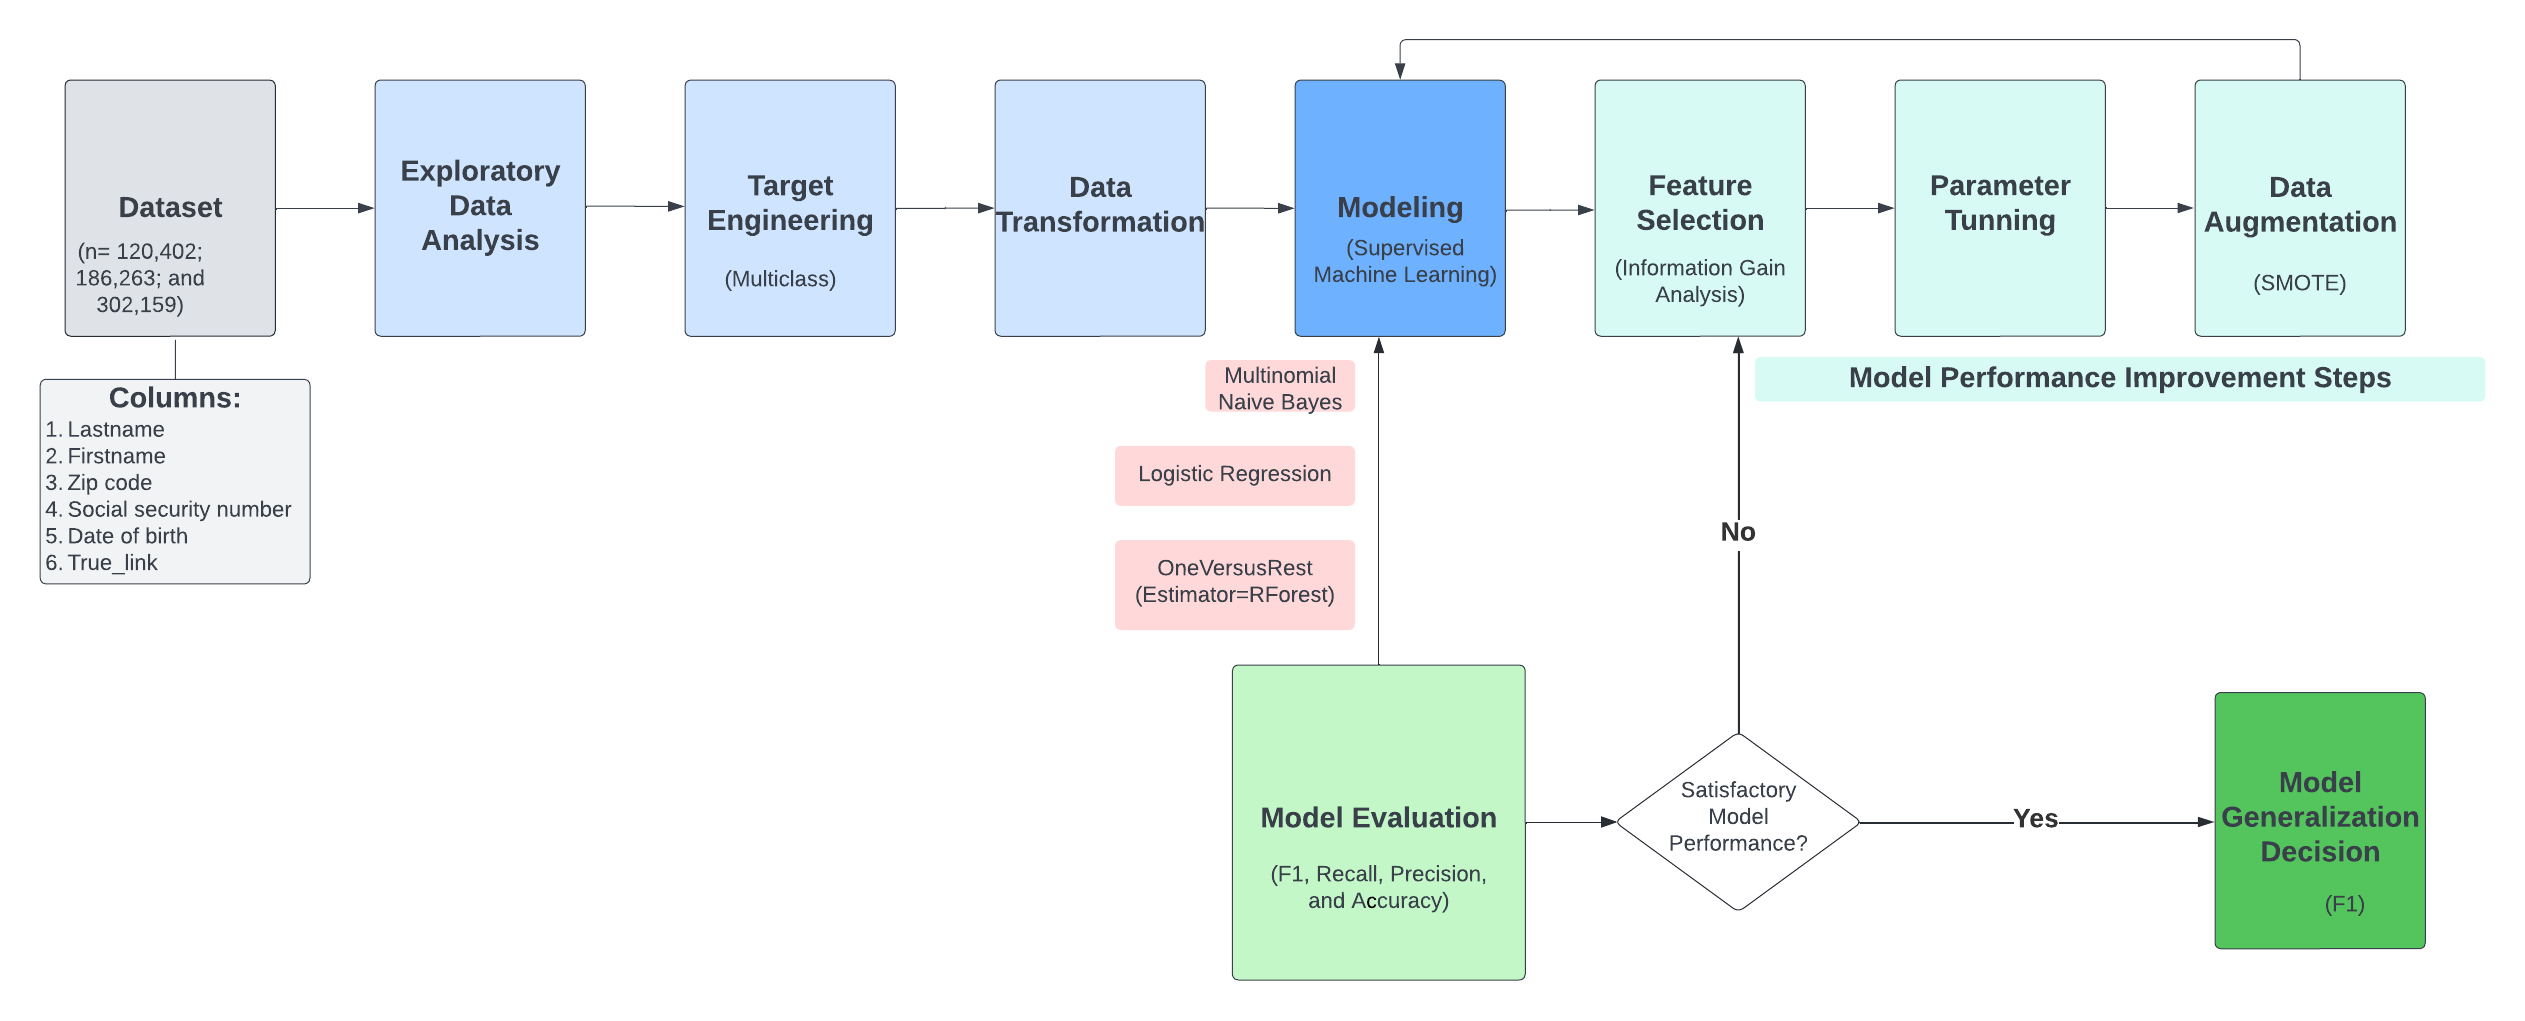

### Import the necessary packages

In [ ]:
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt  # works with seaborn etc to display plots created by seaborn etc
from matplotlib import style # to make the output of matplotlib pretier (all charts then turned red)
style.use("ggplot")# used because I prefer blue color for my charts
plt.rcParams["font.family"] = "Times New Roman"

import seaborn as sns

import plotly.express as plotExp
import plotly.figure_factory as factory_fig
import plotly.graph_objs as graphObj

from sklearn.preprocessing import MinMaxScaler # would handle outliers (data standardization)
from sklearn.preprocessing import LabelEncoder # for transforming Categorical data to Numerical data

#import time

In [ ]:
## So we could display our plots in a cell
%matplotlib inline
from pylab import rcParams
rcParams ['figure.figsize']=10,8 # intending figure size

***** To be able to print multiple output from a cell, we'll let all output come through from Ipython and we'll utilize Jupyter's interactive shell

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [ ]:
# By default, Pandas will display only 10 rows/cols

# Globally set Max rows displayed in output to 20
pd.set_option('display.max_rows', 30)

# Globally set display for Pandas to always display all the columns
#pd.set_option('display.line_width', 5000)
pd.set_option('display.max_columns', None)# Settig to none makes display unlimited, better than putting a number

# Globally set Max rows displayed in output to 20
pd.set_option('display.max_rows', None)  # Great! No deprecation, many rows printed as wanted

# Globally set decimal places Displayed in output to any number of choice, change it prn
pd.set_option('display.precision', 2)

# Globally set floatto avoid getting such values in
#exponent notation, in correlation especially (Worked)
pd.options.display.float_format = '{:20,.4f}'.format 

# Globally set max_colwidth display
pd.options.display.max_colwidth = None # This removes any limit to num of col to be shown

# Globally set display expand_frame_repr
pd.set_option('display.expand_frame_repr', False)





### Read the pickle file containing the comparison output where the blocking variable was lastname to memory 

In [ ]:
pprl_DF2=pd.read_pickle('comparison_output_ln.pkl')


### Exploratory Data Analysis 

In [ ]:
pprl_DF2.info()


In [ ]:
pprl_DF2.head(5)


In [ ]:
pprl_DF2.columns

#### Rename columns as needed, using Dictionary data structure

In [ ]:
pprl_DF2.rename(columns={'dob': 'dateOfBirth',
                         'firstname':'firstName','lasttname':'lastName'}, inplace=True)

In [ ]:
pprl_DF2.info()

#### Plot data distribution to see if data follows Gaussian distribution (many ML algorithms will not do well if data is not normally distributed)

In [ ]:
plt.figure(1, figsize=(15,6))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
sns.distplot(pprl_DF2, bins=10)
plt.title('PPRL Data Distribution')
plt.show()


*****The distribution plot above shows the data does not follow Gaussian (normal) distribution

In [ ]:
####Describe the data and transpose result if you so desire
pprl_DF2.describe().T

In [ ]:
# You may also save the output for reporting purposes

pprl_DataDescrp= pprl_DF2.describe().T # Remember describe only works on numerical data

# You may also save the output for reporting purposes
#pprl_DataDescrp.to_csv('Report: PPRL_DataDescription.csv')


In [ ]:
pprl_DF2.head()
pprl_DF2.isna().sum()# Count the total number of missingness per column
pprl_DF2.shape # Shape is total row bumbers multiplied by total column numbers

#### In case you want to perform auto-descriptive statistics with Pandas Profiling package 

In [ ]:
#!pip install  https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 


In [ ]:
from pandas_profiling import ProfileReport


In [ ]:
#Obtain descriptive statistics of the DataFrame (DF) using Pandas Profiling package from Github

In [ ]:
summaryReport= ProfileReport(pprl_DF2,title='PPRL_UnlabelledData_DescriptiveReport', html={'style':{'full_width':'True'}})

In [ ]:
summaryReport

### Multiclass Classification Target Engineering 

In [ ]:
## Remove the blocking variable and the binary target
pprl_DF2.drop(["true_links", 'lastName'],axis=1, inplace=True)

##### Compute record-pair mean (rowwise average)

In [ ]:
# Round to 1 decimal place to permit float comparison down the road
pprl_DF2['row_Means'] =pprl_DF2.mean(axis=1).round(1) # Round to 1 to permit comparison, based on exp with working wt mock data
pprl_DF2['row_Means'].describe()
pprl_DF2['row_Means'].head()
print('============================')
pprl_DF2.info()


#### Bin the row means and categorize them as matching classes

In [ ]:
# #### View distinct values of matched DF and their frequencies, sort them by frequency as well

pprl_DF2['row_Means'].value_counts().sort_values()

pprl_DF2['matched']=pprl_DF2['row_Means']


pprl_DF2['matched']=pd.cut(pprl_DF2.matched, bins=[
    -0.001, 0.45, 0.75,2.0], labels=['no','mayBe','yes'])

# ##### Check class distribution of the target
pprl_DF2['matched'].value_counts()

##### Plot a bar chart to display the class distribution
pprl_DF2['matched'].value_counts().plot(kind='bar', color='b',
                                        title="Matching Distribution Plot by Classes")

****Both the textual and vizualized distribution results show there is class imbalance in the dataset (against MayBe and Yes). We'll address it at modeling

In [ ]:
pprl_DF2.info()

In [ ]:
pprl_DF2.head(5)

In [ ]:
pprl_DF2.columns

### Exploratory Data Analysis completed 

#### Start modeling-related operations


In [ ]:
# drop firstname based on FImportance, drop row_means as well
pprl_DF2.drop('row_Means', axis=1, inplace=True)

#pprl_DF2.drop('row_Means', axis=1, inplace=True)


##### Create feature vectors

In [ ]:
x =pprl_DF2.drop("matched", axis=1)
y =pprl_DF2.matched


###### Transform categorical data into numerical data
only the target is categorical in this case

In [ ]:
label_encod=LabelEncoder()
label_encod.fit(y)
y=label_encod.transform(y)
classes=label_encod.classes_
classes


In [ ]:
x.shape
y.shape

In [ ]:
##### Import the modelling-related classes


In [ ]:
#!pip install imblearn # Required before importing the imblearn pipeline and SMOTE 


In [ ]:

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from numpy.random import RandomState
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as imbaPipe # The SMOTE class is in the imblearn package.
from imblearn.pipeline import make_pipeline # For gridsearching SMOTE inside Grid


from imblearn.over_sampling import SMOTE # SMOTE= synthetic minority oversampling technique
from imblearn.metrics import classification_report_imbalanced

from sklearn.metrics import recall_score, f1_score, precision_score,roc_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support # For summary table


##### Split the dataset (Create train-test data)

In [ ]:
## Split Data into training and test (you can split as desired, but 70:30% was used here) 

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
# Confirm the Output Dimensions
# We can confirm the dimensions of the data are the same within test and train
# The proportion should also be close to the test_size argument.

x_train.shape
x_test.shape
y_train.shape
y_test.shape

##### Try viewing  the ground truth of some record pairs 


In [ ]:
y_test[655:671] # slicing, so, this excludes the pair of records in index 671

##### Obtain the frequency distribution of each class per data split
**** Remember, these are no longer in DF format but ndarray, so, vlaue_counts() can't work, but we can obtain the same info from the ndarray using np.unique() 


In [ ]:
import collections
collections.Counter(y_test) # we could acheve the same goal using numpy
print('y_test value frequency=========')

unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

print('x_test value frequency=========')

unique, counts = np.unique(x_test, return_counts=True)
dict(zip(unique, counts))


print('y_train value frequency=========')
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

print('x_train value frequency=========')

unique, counts = np.unique(x_train, return_counts=True)
dict(zip(unique, counts))

#### Now scale the train and test data 
***** Do so separately to avoid data leakage

In [ ]:
scaler = MinMaxScaler()# to normalize the values so they could be between 0 and 1.

x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

##### It is expected that scaling put all the training data in a range of 0 and 1

x_train[:5]# Show me the first 5 records in the scaled Xtrain
x_test[:5] # Show me the first 5 records in the scaled Xtest

#### Perform ML Experiments 

#### Build multiple models
***** Steps:

1. Build baseline models
3. Evaluate the models
4. Embark on model performance improvement activities
4. Build optimized models
5. Evaluate the models
6. Identify the most generalizable model

##### Instantiate the intending classifiers and their Scikit Learn pipelines (for baseline models /(Model Set 1)

In [ ]:
nbayesPipe_SK = Pipeline([("dataScaler", scaler), ("naive", MultinomialNB())])

logregPipe_SK = Pipeline([("dataScaler", scaler), ("LogReg", LogisticRegression())]) # Per scikit,newton is as one of thise meant for multic in lo

# Any classifier can be used as an estimator, not only random forest
ovr_ForestPipe_SK=Pipeline([("dataScaler", scaler),
                            ('ovrForest', OneVsRestClassifier(RandomForestClassifier()))])# Notice that it doesn't have to be SVM that we utilize with OVR

### Baseline Models


##### Create a modeling result dataframe

In [ ]:
metrics_DF_pipeSK = pd.DataFrame(index =['Accuracy','Precision','Recall','F1'], 
                          columns=['NBayes', 'OVR','LReg'])

#### Naive Bayes Baseline

In [ ]:

pipe1 = nbayesPipe_SK.steps[1][1]

NBayesmodel= pipe1.fit(x_train, y_train)

y_pred_testBayes= NBayesmodel.predict(x_test)

Bayes_pos_probs =NBayesmodel.predict_proba(x_test)[:,2]# index2 holds the predicted probabs for "yes"
Bayes_pos_probs[10] # Show me the 11th of the "yes" probabilities  

metrics_DF_pipeSK.loc['Accuracy', 'NBayes']= accuracy_score(y_pred = y_pred_testBayes,
                                                            y_true=y_test)
metrics_DF_pipeSK.loc['Precision', 'NBayes']= precision_score(y_pred = y_pred_testBayes,
                                                              y_true=y_test,average='weighted')
metrics_DF_pipeSK.loc['Recall', 'NBayes']= recall_score(y_pred = y_pred_testBayes,
                                                        y_true=y_test,average='weighted')
metrics_DF_pipeSK.loc['F1', 'NBayes']= f1_score(y_pred = y_pred_testBayes,
                                                y_true=y_test,average='weighted')
# classification_report
train_y_predBayes= NBayesmodel.predict(x_train)
print('Bayes train :', classification_report(y_train, train_y_predBayes),flush=True)
print('Bayes test :', classification_report(y_test, y_pred_testBayes),flush=True)

# Get confusion matrix

sns.set(rc = {'figure.figsize': (15, 8)})
conf_matrix = confusion_matrix(y_pred_testBayes, y_test)
np.set_printoptions(precision = 2)
print("Print Bayes's crosstab (Conf matrix) :" '\n',"===================",'\n',conf_matrix)# Matrix Table, not the graphic one

# Now Plot the Conf Matrix

#sns.heatmap(conf_matrix, annot=True, fmt='d')

group_names = ['T MayB','F MayB','F MayB',
               'F No (F-Neg : T2Error)','T No (T-Neg)','F No (F-Neg : T2Error)',
               'F Yes (F-Pos : T1Error)','F Yes (F-Pos : T1Error)','T Yes (T-Pos)']

group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in 
                                         conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)


sns.heatmap(conf_matrix, annot=labels, fmt='', cmap="Blues")# or cmap="OrRd", "OrRd_r" colors


plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title("CMatrix for NBayes Baseline: PPRL, Multiclass [noLastname]")
#plt.savefig('')
plt.show()  # SAVE AS THEY SHOW


#### OVR Baseline

In [ ]:

pipe2 = ovr_ForestPipe_SK.steps[1][1]
ovrmodel= pipe2.fit(x_train, y_train)

Y_pred_testOVR= ovrmodel.predict(x_test)
OVR_pos_probs =ovrmodel.predict_proba(x_test)[:,2]# this is  y_score in scikit


metrics_DF_pipeSK.loc['Accuracy', 'OVR']= accuracy_score(y_pred = Y_pred_testOVR,
                                                            y_true=y_test)
metrics_DF_pipeSK.loc['Precision', 'OVR']= precision_score(y_pred = Y_pred_testOVR,
                                                              y_true=y_test, average='weighted')
metrics_DF_pipeSK.loc['Recall', 'OVR']= recall_score(y_pred = Y_pred_testOVR,
                                                        y_true=y_test,average='weighted')
metrics_DF_pipeSK.loc['F1', 'OVR']= f1_score(y_pred = Y_pred_testOVR,
                                                y_true=y_test,average='weighted')

# classification_report
train_y_predOVR= ovrmodel.predict(x_train)
print('OVR train :', classification_report(y_train, train_y_predOVR),flush=True)
print('OVR test :', classification_report(y_test, Y_pred_testOVR),flush=True)

# Get confusion matrix

sns.set(rc = {'figure.figsize': (15, 8)})
conf_matrix = confusion_matrix(Y_pred_testOVR, y_test)
np.set_printoptions(precision = 2)
print("Print OVR's crosstab (Conf matrix) :" '\n',"===================",'\n',conf_matrix)# Matrix Table, not the graphic one

# Now Plot the Conf Matrix

#sns.heatmap(conf_matrix, annot=True, fmt='d')
#group_names = ['True MayB','False MayB','False MayB','False No','True No','False No','False Yes','False Yes','True Yes']
group_names = ['T MayB','F MayB','F MayB',
               'F No (F-Neg : T2Error)','T No (T-Neg)','F No (F-Neg : T2Error)',
               'F Yes (F-Pos : T1Error)','F Yes (F-Pos : T1Error)','T Yes (T-Pos)']

group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in 
                                         conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)
    
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap="Blues")# cmap="OrRd", "OrRd_r" colors
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title("CMatrix for OVR-Forest Baseline: PPRL, Multiclass [noLastname]")
#plt.savefig('')# must come before the show function
plt.show()  



### LReg Baseline

In [ ]:

pipe4 =  logregPipe_SK.steps[1][1]
logregmodel= pipe4.fit(x_train, y_train)

y_pred_testlogReg= logregmodel.predict(x_test)
lreg_pos_probs =logregmodel.predict_proba(x_test)[:,2]# this is  y_score in scikit


metrics_DF_pipeSK.loc['Accuracy', 'LReg']= accuracy_score(y_pred = y_pred_testlogReg,
                                                            y_true=y_test)
metrics_DF_pipeSK.loc['Precision', 'LReg']= precision_score(y_pred = y_pred_testlogReg,
                                                              y_true=y_test, average='weighted')
metrics_DF_pipeSK.loc['Recall', 'LReg']= recall_score(y_pred = y_pred_testlogReg,
                                                        y_true=y_test,average='weighted')
metrics_DF_pipeSK.loc['F1', 'LReg']= f1_score(y_pred = y_pred_testlogReg,
                                                y_true=y_test,average='weighted')

# classification_report
train_y_predlreg= logregmodel.predict(x_train)
print('Lreg Sklearn train :', classification_report(y_train, train_y_predlreg),flush=True)
print('Lreg Sklearn test :', classification_report(y_test, y_pred_testlogReg),flush=True)

# Get confusion matrix

sns.set(rc = {'figure.figsize': (15, 8)})
conf_matrix = confusion_matrix(y_pred_testlogReg, y_test)
np.set_printoptions(precision = 2)
print("Print LReg Sklearn crosstab (Conf matrix) :" '\n',"===================",'\n',conf_matrix)# Matrix Table, not the graphic one

# Now Plot the Conf Matrix

#sns.heatmap(conf_matrix, annot=True, fmt='d')
group_names = ['T MayB','F MayB','F MayB',
               'F No (F-Neg : T2Error)','T No (T-Neg)','F No (F-Neg : T2Error)',
               'F Yes (F-Pos : T1Error)','F Yes (F-Pos : T1Error)','T Yes (T-Pos)']

group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in 
                                         conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap="Blues")# cmap="OrRd", "OrRd_r" colors
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title("CMatrix for LReg Baseline: PPRL, Multiclass [noLastname]")
#plt.savefig('')
plt.show() 


#### Results dataframe

In [ ]:
print('== Score Table: PPRL Model Set 1 (Baseline data) ==')

100*metrics_DF_pipeSK
### STORE THE DATAFRAME OF METRIC RESULT IN A VARIABLE AND SAVE IT AS A CSV FILE

lName_MClass_ResultTable=100*metrics_DF_pipeSK


In [ ]:
print('PLOT RESULT VISUALS')
fig, ax = plt.subplots(figsize = (8,5))
metrics_DF_pipeSK.plot(kind='barh', ax=ax)# wondering why the legend is no longer well positioned
ax.grid()

plt.title('Subplots of PPRL MultiClass Models And Scores: Baseline noLastname')


*****The performance of the baseline models is not satisfactory and it's unreliable due to the imbalance nature of the data. Therefore, we need to carry out some model improvement operations

# Pause Here!!!
### Go to the file named, 'PPRL_Multiclass_Fselection+ParamTuning_2022' to perform two model performance improvement activities (Feature selection, and Parameter tuning)

### Now Use the Optimized Algorithms for Further Modeling


In [ ]:
pprl_DF2.drop('firstName', axis=1, inplace=True)# based on FImportance result

### Use the output of parameter tuning and K search to create full imblearn pipelines

##### Full Imblearn pipeline for NBayes


In [ ]:
smNbayes_Pipe= imbaPipe([('smote', SMOTE(sampling_strategy ="auto", k_neighbors=9, random_state=40)),
                                           ("dataScaler", scaler), ("naive", MultinomialNB(alpha=2))])# nbayes defined above as NBayes()



##### Full Imblearn pipeline for OneVersusRest

In [ ]:
smOvrRforest_Pipe = imbaPipe([('smote', SMOTE(sampling_strategy ="auto", k_neighbors=9, 
                                              random_state=40)),
                                ("dataScaler", scaler), 
                          ("oneVRestRF", OneVsRestClassifier(RandomForestClassifier(
                              bootstrap =False,max_depth=25, min_samples_split= 2,
                             n_estimators = 5,random_state= 42)))])# min_samples_leaf= 2


                             
                             

#### Full Imblearn Pipeline for LReg

In [ ]:

smLReg_Pipe = imbaPipe([('smote', SMOTE(sampling_strategy ="auto", k_neighbors=1, random_state=40)),
                              ("dataScaler", scaler), ("LReg", LogisticRegression(C=10, 
                                                                            penalty='l2',
                                                                        solver='newton-cg'))])

## LReg will automatically use multi_class='multinomial', penalty='l2' when it discovers it's a multiclass problem


### Construct optimized models with the imblearn pipeline

In [ ]:
## Create a Dataframe of Model Eval Metrics, with classifier's name as their columns

In [ ]:
metrics_DF_pipeSM = pd.DataFrame(index =['Accuracy','Precision','Recall','F1'], 
                          columns=['NBayes', 'OVR', 'LReg'])

#### Naive Bayes Optimized

In [ ]:

pipeline1 = smNbayes_Pipe
x_train.shape
y_train.shape

# Augment the training data
x_train_oversampled, y_train_oversampled = pipeline1.steps[0][1].fit_resample(x_train, y_train)
x_train_oversampled.shape
y_train_oversampled.shape

NBayesmodel= pipeline1.steps[2][1].fit(x_train_oversampled, y_train_oversampled)

y_pred_testNBayes= NBayesmodel.predict(x_test)
NBayes_pos_probs =NBayesmodel.predict_proba(x_test)[:,2]


metrics_DF_pipeSM.loc['Accuracy', 'NBayes']= accuracy_score(y_pred = y_pred_testNBayes,
                                                            y_true=y_test)
metrics_DF_pipeSM.loc['Precision', 'NBayes']= precision_score(y_pred = y_pred_testNBayes,
                                                              y_true=y_test,average='weighted')
metrics_DF_pipeSM.loc['Recall', 'NBayes']= recall_score(y_pred = y_pred_testNBayes,
                                                        y_true=y_test,average='weighted')
metrics_DF_pipeSM.loc['F1', 'NBayes']= f1_score(y_pred = y_pred_testNBayes,
                                                y_true=y_test,average='weighted')
# classification_report
train_y_predNBayes= NBayesmodel.predict(x_train_oversampled)
print('NBayes train :')
print(classification_report(y_train_oversampled, train_y_predNBayes))

print('NBayes test :')
print(classification_report(y_test, y_pred_testNBayes))

# Get matrix

sns.set(rc = {'figure.figsize': (15, 8)})
conf_matrix = confusion_matrix(y_pred_testNBayes, y_test)
np.set_printoptions(precision = 2)
print("Print NBayes's crosstab (Conf matrix) :" '\n',"===================",'\n',conf_matrix)# Matrix Table, not the graphic one

# Now Plot the Conf Matrix

group_names = ['T MayB','F MayB','F MayB',
               'F No (F-Neg : T2Error)','T No (T-Neg)','F No (F-Neg : T2Error)',
               'F Yes (F-Pos : T1Error)','F Yes (F-Pos : T1Error)','T Yes (T-Pos)']


group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in 
                                         conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)
   
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap="Blues")# other colors::cmap="OrRd", "OrRd_r" colors
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title("CMatrix for NBayes Model: PPRL, AugmMulticlass [noLastname]")
#plt.savefig('')
plt.show()  


#### OVR Optimized

In [ ]:

pipeline2 = smOvrRforest_Pipe

x_train_oversampled, y_train_oversampled = pipeline2.steps[0][1].fit_resample(x_train, y_train)


print('------Fit the pipeline on the data. I copied the training set to another variable"')


x_train_oversampled.shape
y_train_oversampled.shape

ovrModel= pipeline2.steps[2][1].fit(x_train_oversampled, y_train_oversampled)

y_pred_testOVR= ovrModel.predict(x_test)
y_pred_testOVR[5]
OVR_pos_probs =ovrModel.predict_proba(x_test)[:,2]# this is  y_score in scikit

OVR_pos_probs

metrics_DF_pipeSM.loc['Accuracy', 'OVR']= accuracy_score(y_pred = y_pred_testOVR,
                                                            y_true=y_test)
metrics_DF_pipeSM.loc['Precision', 'OVR']= precision_score(y_pred = y_pred_testOVR,
                                                              y_true=y_test, average='weighted')
metrics_DF_pipeSM.loc['Recall', 'OVR']= recall_score(y_pred = y_pred_testOVR,
                                                        y_true=y_test,average='weighted')
metrics_DF_pipeSM.loc['F1', 'OVR']= f1_score(y_pred = y_pred_testOVR,
                                                y_true=y_test,average='weighted')

# classification_report
train_y_predOVR= ovrModel.predict(x_train_oversampled)
print('OVR train :', classification_report(y_train_oversampled, train_y_predOVR),flush=True)
print('OVR test :', classification_report(y_test, y_pred_testOVR),flush=True)

# GET CMATRIX

sns.set(rc = {'figure.figsize': (15, 8)})
conf_matrix = confusion_matrix(y_pred_testOVR, y_test)
np.set_printoptions(precision = 2)
print("Print OVR's crosstab (Conf matrix) :" '\n',"===================",'\n',conf_matrix)# Matrix Table, not the graphic one

#pd.crosstab(ovrModel.y_pred_testOVR, ovrModel.y_test)
    
# Now Plot the Conf Matrix

sns.heatmap(conf_matrix, annot=True, fmt='d')
#group_names = ['True Neg','False Neg','False Pos','True Pos']# This is an array of size 4, but we have a multiclass, so,size9

group_names = ['T MayB','F MayB','F MayB',
               'F No (F-Neg : T2Error)','T No (T-Neg)','F No (F-Neg : T2Error)',
               'F Yes (F-Pos : T1Error)','F Yes (F-Pos : T1Error)','T Yes (T-Pos)']


group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in 
                                         conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

#labels=classes

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap="Blues")# cmap="OrRd", "OrRd_r" colors
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title("CMatrix for OVR-Forest Model: PPRL, AugmMulticlass [noLastname]")
#plt.savefig('')
plt.show()  # SAVE AS THEY SHOW

#### LReg Optimized

In [ ]:

pipeline4 = smLReg_Pipe
# Augment the training data

x_train_oversampled, y_train_oversampled = pipeline4.steps[0][1].fit_resample(x_train, y_train)
x_train_oversampled.shape

y_train_oversampled.shape
LRegModel= pipeline4.steps[2][1].fit(x_train_oversampled, y_train_oversampled)

y_pred_testLReg= LRegModel.predict(x_test)
LReg_pos_probs =LRegModel.predict_proba(x_test)[:,2]# this is  y_score in scikit


metrics_DF_pipeSM.loc['Accuracy', 'LReg']= accuracy_score(y_pred = y_pred_testLReg,
                                                            y_true=y_test)
metrics_DF_pipeSM.loc['Precision', 'LReg']= precision_score(y_pred = y_pred_testLReg,
                                                              y_true=y_test,average='weighted')
metrics_DF_pipeSM.loc['Recall', 'LReg']= recall_score(y_pred = y_pred_testLReg,
                                                        y_true=y_test,average='weighted')
metrics_DF_pipeSM.loc['F1', 'LReg']= f1_score(y_pred = y_pred_testLReg,
                                                y_true=y_test,average='weighted')

# classification_report
train_y_predLReg= LRegModel.predict(x_train_oversampled)
print('LReg train :', classification_report(y_train_oversampled, train_y_predLReg),flush=True)
print('LReg test :', classification_report(y_test, y_pred_testLReg),flush=True)

# Get Confusion Matrix

sns.set(rc = {'figure.figsize': (15, 8)})
conf_matrix = confusion_matrix(y_pred_testLReg, y_test)
np.set_printoptions(precision = 2)
print("Print LReg's crosstab (Conf matrix) :" '\n',"===================",'\n',conf_matrix)# Matrix Table, not the graphic one

#Now Plot the Conf Matrix

group_names = ['T MayB','F MayB','F MayB',
               'F No (F-Neg : T2Error)','T No (T-Neg)','F No (F-Neg : T2Error)',
               'F Yes (F-Pos : T1Error)','F Yes (F-Pos : T1Error)','T Yes (T-Pos)']

group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in 
                                         conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap="Blues")# other colors: cmap="OrRd", "OrRd_r" colors
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title("CMatrix for LReg Model: PPRL, AugmMulticlass [FirstORlastname]")
#plt.savefig('')
plt.show() 


In [ ]:
### RESULT DATAFRAME

In [ ]:
print('== Score Table: PPRL Model Set 2 (Augmented data) ==')

Aug_firstORlast_MClass_ResultTable=100*metrics_DF_pipeSM
Aug_firstORlast_MClass_ResultTable

In [ ]:
### PLOT RESULT VISUALS

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
metrics_DF_pipeSM.plot(kind='barh', ax=ax)
ax.grid()

plt.title('Subplots of PPRL MultiClass Models And Scores: Augm_lastname')


In [ ]:
print('Firstname data says,"Awesome!":::::::::::::::::::::::::')